In [1]:
import pandas as pd
import numpy as np
import os 
import pathlib
from pathlib import Path

In [2]:
import sys
sys.path.append("../")
from common import Toolkit

In [3]:
import matplotlib.pyplot as plt

In [4]:
def copy_globals():
    glb = globals()
    
    def func():
        return glb
    
    return func

In [5]:
def batch_load_csv(folder, *files):
    input_dir = Path(folder)
    return (pd.read_csv(input_dir / f) for f in files)

In [6]:
def get_num_cat_cols(df):
    assert isinstance(df, pd.DataFrame)
    cat_cols = [col for col, dtype in df.dtypes.items() if dtype == object]
    num_cols = [col for col in df.columns if col not in cat_cols]
    return num_cols, cat_cols

In [7]:
tk = Toolkit(copy_globals())

In [8]:
# ================================
# Part 1: Overview of the datasets
# ================================

In [9]:
!ls ../data/house_pricing/

data_description.txt  sample_submission.csv  test.csv  train.csv


In [10]:
DATA_FILES = ['sample_submission.csv',  'test.csv',  'train.csv']
DATA_FOLDER = '../data/house_pricing'
raw_subm, raw_test, raw_train = batch_load_csv(DATA_FOLDER, *DATA_FILES)

In [11]:
tk.batch_print_shape(raw_subm, raw_train, raw_test)

Shape
-----
raw_subm: (1459, 2)
raw_train: (1460, 81)
raw_test: (1459, 80)



In [12]:
raw_num_cols, raw_cat_cols = get_num_cat_cols(raw_train)
print("{} Numerical Columns:\n{}".format(len(raw_num_cols), raw_num_cols))
print("{} Categorical Columns:\n{}".format(len(raw_cat_cols), raw_cat_cols))

38 Numerical Columns:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
43 Categorical Columns:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fir

In [13]:
raw_num_cols.remove("Id")  # it's useless
raw_num_cols.remove("SalePrice")  # also useless

In [14]:
# ============================================
# Part 2: Visualization for Numerical Features
# ============================================

In [15]:
# Adapted from the codes I wrote before
def plot_numerical_feat(x, name, ax, bins=None, **kw):
    x_clean = x[~np.isnan(x)]
    nunique = len(np.unique(x_clean))
    bins = bins if bins is not None else 100 if nunique > 30 else 10 if nunique < 10 else 'auto'
    ax.hist(x_clean, bins=bins, **kw)
    ax.set_title("{} Distribution".format(name))
    
    
def plot_numerical_feats(df, num_cols=None, ncols=3, height_per_plot=6):
    # df_name = get_var_name(df)
    df_name = tk.get_var_name(df)
    print(df_name)
    print("-" * len(df_name))
    if num_cols is None:
        num_cols = df.dtypes[df.dtypes != object].index.tolist()
    num_col_counts = len(num_cols)
    nrows = int(np.ceil(num_col_counts / 3))
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*height_per_plot))
    for i,feat in enumerate(num_cols):
        ix = i // ncols
        iy = i % ncols
        plot_numerical_feat(df[feat], feat, axs[ix][iy])
    for i in range(num_col_counts, nrows*ncols):
        fig.delaxes(axs.flatten()[i])
    plt.show()
    print()
    

def plot_numerical_feats_double(df1, df2, num_cols=None, ncols=3, height_per_plot=6):
    # df_name = get_var_name(df)
    df1_name = tk.get_var_name(df1)
    df2_name = tk.get_var_name(df2)
    df_names = "{} and {}".format(df1_name, df2_name)
    print(df_names)
    print("-" * len(df_names))
    if num_cols is None:
        num_cols1 = df1.dtypes[df1.dtypes != object].index.tolist()
        num_cols2 = df2.dtypes[df2.dtypes != object].index.tolist()
        num_cols = num_cols1 and num_cols2
    num_col_counts = len(num_cols)
    nrows = int(np.ceil(num_col_counts / 3))
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*height_per_plot))
    for i,feat in enumerate(num_cols):
        ix = i // ncols
        iy = i % ncols
        ax = axs[ix][iy] if nrows > 1 else axs[iy]
        if feat not in df2.columns:
            plot_numerical_feat(df1[feat], feat, ax, alpha=.5, density=True)
        elif feat not in df1.columns:
            plot_numerical_feat(df2[feat], feat, ax, alpha=.5, density=True)
        else:  #  feature appears in both DataFrame
            vals = np.concatenate([df1[feat].values, df2[feat].values])
            nunique = len(np.unique(vals))
            nbins = 100 if nunique > 30 else 10 if nunique < 10 else min(nunique, 20)
            _, bins = pd.cut(vals, bins=nbins, retbins=True)
            plot_numerical_feat(df1[feat], feat, ax, bins, alpha=.5, label=df1_name, density=True)
            plot_numerical_feat(df2[feat], feat, ax, bins, alpha=.5, label=df2_name, density=True)
            ax.legend([df1_name, df2_name])
        ax.legend([df1_name, df2_name])
    for i in range(num_col_counts, nrows*ncols):
        fig.delaxes(axs.flatten()[i])
    plt.show()
    print()
        
        
# def batch_plot_numerical_feats(ncols=3, height_per_plot=6, *args):
#     for arg in args:
#         plot_numerical_feats(arg, num_cols=None, ncols=ncols, height_per_plot=height_per_plot)

raw_train and raw_test
----------------------


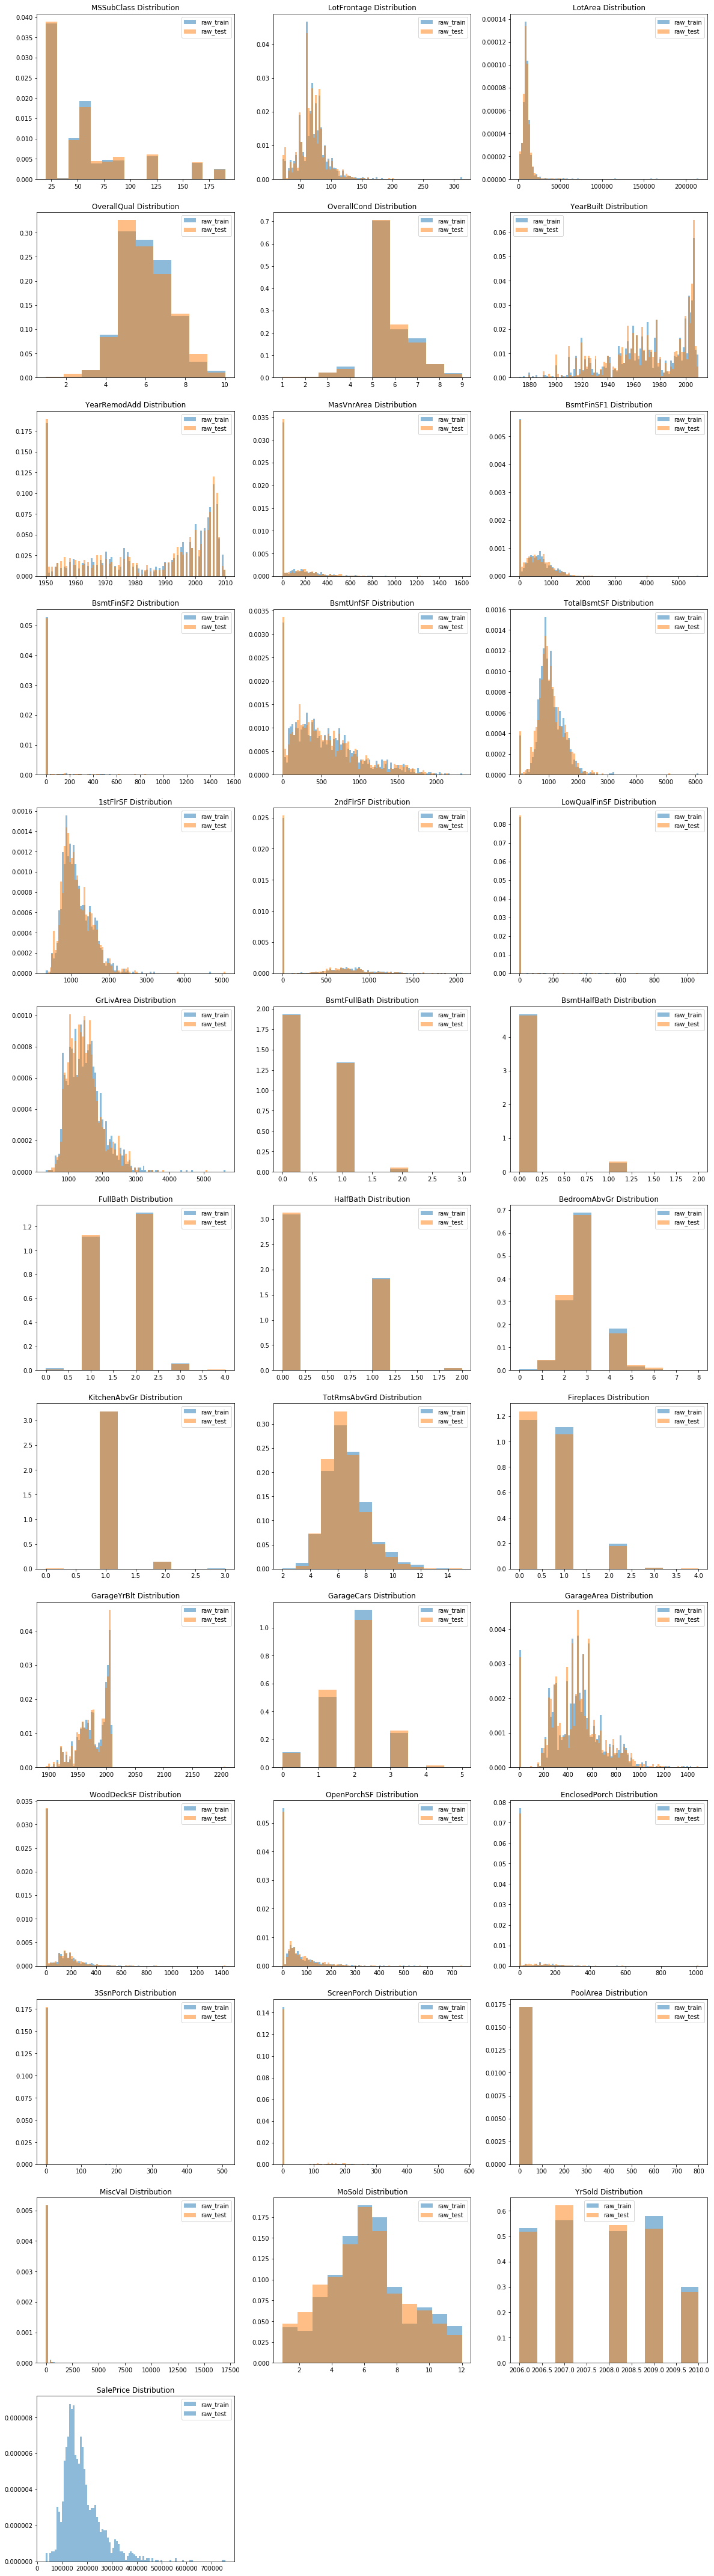

In [16]:
plot_numerical_feats_double(df1=raw_train, df2=raw_test, num_cols=raw_num_cols+['SalePrice'])

In [17]:
# Conclusion from the above plots for NUMERICAL features
# 1. For every single numerical feature, the distributions of train and test sets are similar, 
#    we don't need to handle it much 
# 2. Some of them might be regarded as categorical features: 'MSSubClass', 'OverallQual',
#    'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
#    'KitchenAbvGr', 'TotRmsAbvGrd', 'FirePlaces', 'GarageCars', 'MoSold', 'YrSold'.
#    They can be sorted out automatically by counting number of unique values
# 3. One feature looks weird: 'PoolArea'. It seems to have only one value, and hence useless
# 4. Some distribute in a really uneven or weird way.
#    1) Some are almost dominated by one single value (mostly 0's): 'MasVnrArea', 'BsmtFinSF1',
#       'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
#       '3SsnPorch', 'ScreenPorch', 'MiscVal'.
#       They might be sorted out automatically by calculating skewness
#    2) Some though are not dominated by 0's or any other single value, but still look weird
#       because its smoothness is broken by a 'peak' suddenly and unexpectedly appeared:
#       'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea'
# 4. There is one thing I missed: the number of NaN. We need to handle it too

In [18]:
# ==============================================
# Part 3: Visualization for Categorical Features
# ==============================================

In [19]:
# Adapted from https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [20]:
def plot_categorical_feat(x, name, ax, keys=None, density=True, plot_nan=True, shift=None, **kw):
    nan_idx = pd.isnull(pd.Series(x))
    x_clean = x[~nan_idx]
    if keys is None:
        vals = x_clean.value_counts()
        keys = vals.index
        counts = vals.values
    else:
        vals = x_clean.value_counts()
        counts = np.array([vals.get(k, 0) for k in keys])
    if plot_nan:
        keys = ['[NaN]'] + list(keys)
        counts = np.array([np.sum(nan_idx)] + list(counts))
    keys = [i+shift for i in range(len(keys))] if shift is not None else keys
    counts = counts / len(x) if density else counts
    ax.bar(keys, counts, **kw)
    ax.set_title("{} Distribution".format(name))
    

def plot_categorical_feats(df, cat_cols=None, ncols=3, height_per_plot=6):
    # df_name = get_var_name(df)
    df_name = tk.get_var_name(df)
    print(df_name)
    print("-" * len(df_name))
    if cat_cols is None:
        cat_cols = df.dtypes[df.dtypes == object].index.tolist()
    num_col_counts = len(cat_cols)
    nrows = int(np.ceil(num_col_counts / 3))
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*height_per_plot))
    for i,feat in enumerate(cat_cols):
        ix = i // ncols
        iy = i % ncols
        plot_categorical_feat(df[feat], feat, axs[ix][iy])
    for i in range(num_col_counts, nrows*ncols):
        fig.delaxes(axs.flatten()[i])
    plt.show()
    print()
    

def plot_categorical_feats_double(df1, df2, cat_cols=None, ncols=3, height_per_plot=6):
    # df_name = get_var_name(df)
    df1_name = "{}(left)".format(tk.get_var_name(df1))
    df2_name = "{}(right)".format(tk.get_var_name(df2))
    df_names = "{} and {}".format(df1_name, df2_name)
    print(df_names)
    print("-" * len(df_names))
    if cat_cols is None:
        cat_cols1 = df1.dtypes[df1.dtypes == object].index.tolist()
        cat_cols2 = df2.dtypes[df2.dtypes == object].index.tolist()
        cat_cols = cat_cols1 and cat_cols2
    num_col_counts = len(cat_cols)
    nrows = int(np.ceil(num_col_counts / 3))
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*height_per_plot))
    for i,feat in enumerate(cat_cols):
        ix = i // ncols
        iy = i % ncols
        ax = axs[ix][iy]  if nrows > 1 else axs[iy]
        if feat not in df2.columns:
            plot_categorical_feat(df1[feat], feat, ax, alpha=.5, density=True)
        elif feat not in df1.columns:
            plot_categorical_feat(df2[feat], feat, ax, alpha=.5, density=True)
        else:  #  feature appears in both DataFrame
            vals = np.concatenate([df1[feat].values, df2[feat].values])
            keys = pd.Series(vals).value_counts().index.tolist()
            nkeys = len(keys)
            cmap = get_cmap(max(nkeys + 1, 8))
            colors = [cmap(n) for n in range(nkeys+1)]
            plot_categorical_feat(df1[feat], feat, ax, keys, color=colors, edgecolor='black', width=.4, label=df1_name)
            plot_categorical_feat(df2[feat], feat, ax, keys, color=colors, edgecolor='black', shift=.4, width=.4, label=df2_name)
            ax.legend([df1_name, df2_name])
        ax.legend([df1_name, df2_name])
    for i in range(num_col_counts, nrows*ncols):
        fig.delaxes(axs.flatten()[i])
    plt.show()
    print()

raw_train(left) and raw_test(right)
-----------------------------------


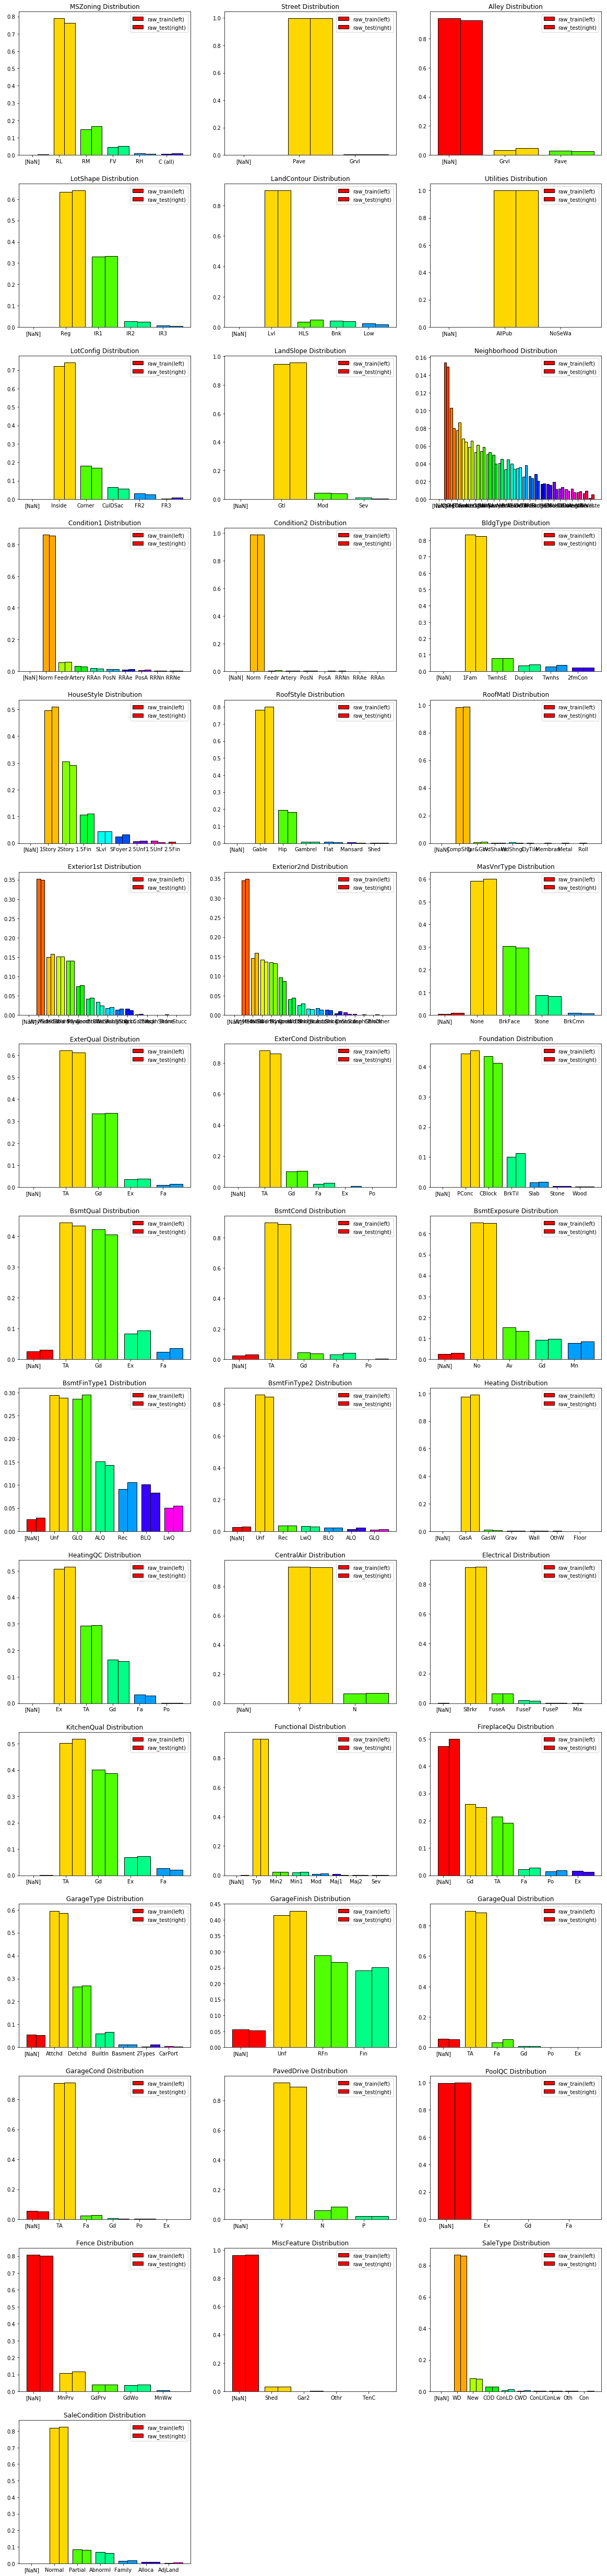

In [21]:
plot_categorical_feats_double(raw_train, raw_test)

In [22]:
# Several problems similar to numerical features
# 1. Some contains too much NaN (which I missed for numerical features): 'Alley', 'FireplaceQu', 'PoolQC',
#    'Fence', 'MiscFeature'
# 2. Some distribute in a too long-tailed way, i.e. they are almost dominated by one single option, or/and there are too
#    many options being the minority, which is hard to learn:
#    'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType',
#    'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional',
#    'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'